# Project Title Using Deep Learning: By Daniel

**To run this notebook, you can simply open it with Google Colab [here](https://colab.research.google.com/github/SalChem/Fastai-iNotes-iTutorials/blob/master/Image_Recognizer_Tutorial.ipynb).**

<br>Once in Colab, **make sure to change the following to enable GPU backend,** <br>
> Runtime -> Change runtime type -> Hardware Accelerator -> GPU

### Let's start...


## 1. Image Dataset Download and Setup

In [ ]:
# !sudo apt-get install python3.7
# !sudo apt-get update -y
# !sudo update-alternatives --install /usr/bin/python3 python3/usr/bin/python3.7 1
# !sudo update-alternatives --config python3

In [ ]:
%%capture
#!wget "https://www.dropbox.com/s/35ithckx6vqryob/Monkeys_Faces_Dataset.tar?dl=0" -O Monkeys_Faces_Dataset.tar
#!tar --warning=no-unknown-keyword -xzf Monkeys_Faces_Dataset.tar

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2. Image Recognition

### Initialization

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
#!touch "/content/gdrive/My Drive/sample_file2.txt"

In [ ]:
bs = 16  #batch size: if your GPU is running out of memory, set a smaller batch size, i.e 16
sz = 224 #image size
PATH = "/content/gdrive/My Drive/daniel_test"
PATH

'/content/gdrive/My Drive/daniel_test'

In [ ]:
import os

PATH is the path containing all the class folders, specify the path of your folders.

Let's retrieve the image classes,

In [ ]:
classes = ["/content/gdrive/MyDrive/daniel_test"]
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d)
print ("There are ", len(classes), "classes...:\n", classes)

There are  9 classes...:
 ['/content/gdrive/MyDrive/daniel_test', 'scratch_neck', 'thread_top', 'daniel', 'manipulated_front', 'scratch_head', 'good', 'thread_side', 'models']


Let's verify there are not any corrupt images that cannot be read. If found any, they will simply be deleted.

In [ ]:
def verify_images(fn):
    "Confirm that `fn` can be opened"
    try:
        im = Image.open(fn)  # uses PIL.Image to open an image at fn
        im.draft(im.mode, (32,32))
        im.load()
        return True
    except: return False

In [ ]:
# for c in classes:
#     print ("Class:", c)
#     verify_images(os.path.join(PATH, c), delete=True);

### Creating and training the classifier

Let's split our dataset to 80% for training and 20% for validation,

In [ ]:
bs = 16  #batch size: if your GPU is running out of memory, set a smaller batch size, i.e 16
sz = 224 #image size
#PATH = './your main path/'

In [ ]:
from fastai.vision.data import ImageDataLoaders

In [ ]:
data = ImageDataLoaders.from_folder(PATH, valid_pct=0.2, size=sz, bs=bs)

In [ ]:
# data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0.2).normalize(imagenet_stats)

In [ ]:
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 166 training images and 41 validation images.


Let's visualize some images from different classes,

In [ ]:
# set PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6, max_split_size_mb:128

# set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128'

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

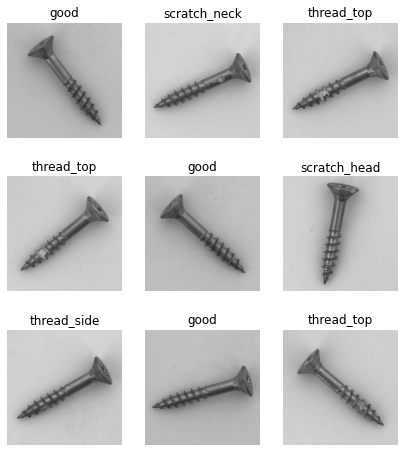

In [ ]:
data.show_batch(nrows=3, figsize=(7,8))

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

NameError: ignored

Let's build our Deep Convolutional Neural Network (CNN),

In [ ]:
# learn = cnn_learner(data, models.resnet34, metrics=accuracy)

from fastai.vision.all import *

# timm_arch = 'regnetx_004'
# dls = ImageDataLoaders.from_folder(PATH, train="train", valid="val", item_tfms=Resize(256))
# learn = vision_learner(data, timm_arch, metrics=accuracy)
# learn.fit_one_cycle(5)

learn = vision_learner(data, resnet18, metrics=error_rate)
learn.fine_tune(epochs=10)
# learn.fine_tune(4)​
# learn.fit_one_cycle(5)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.566549,4.545416,0.878049,01:23


epoch,train_loss,valid_loss,error_rate,time
0,1.156044,2.494275,0.780488,00:11
1,0.858984,1.719962,0.463415,00:11
2,0.667389,2.158155,0.463415,00:12
3,0.536308,2.376634,0.390244,00:12
4,0.441169,2.199010,0.365854,00:11
5,0.375723,2.012863,0.390244,00:12
6,0.315064,1.194535,0.365854,00:12
7,0.268915,0.689965,0.268293,00:11
8,0.228058,0.620049,0.292683,00:12
9,0.194775,0.600236,0.341463,00:11


In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  184028 KB |    7712 MB |    4858 GB |    4858 GB |\n|       from large pool |  170496 KB |    7699 MB |    4856 GB |    4856 GB |\n|       from small pool |   13532 KB |      14 MB |       1 GB |       1 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  184028 KB |    7712 MB |    4858 GB |    4858 GB |\n|       from large pool |  170496 KB |    7699 MB |

The CNN architecture used here is [ResNet34](https://arxiv.org/pdf/1512.03385.pdf). ResNet architecture has had great success within the last few years and still considered state-of-the-art, so I believe there is great value in discussing it a bit. If you are interested solely in getting the Image Recognizer to work, feel free to skip the next few paragraphs.

First, what’s CNN again? We can think of a Convolutional Neural Network (CNN or convNet) as a list of layers that transform the image volume into an output volume, which can be a class score as it is the case in this tutorial. For an in-depth read, I would highly recommend [Convolutional Neural Networks](http://cs231n.github.io/convolutional-networks/) from Stanford’s CS231 class.

What is special about ResNet architecture is how it tackles _the degradation problem_ most common in deep networks, where the model accuracy gets saturated and then degrades rapidly. It is important to note here that although some assume that the core idea behind ResNets is overcoming the notorious _vanishing gradient problem_, where gradients get infinitely small as they back-propagate to earlier layers of the network, this is not quite true.

Resnet architecture introduces an "identity shortcut connection" or often referred to as a "skip connection", which skips one or more layers. The shortcut connections simply perform identity mappings, and their outputs are added to
the outputs of the stacked layers, as shown in the figure below. The skip function creates what is known as a residual block, F(x) in our figure, and that's where the name Residual Nets (ResNets) came from.  

<img width="286" alt="Tutorial1_img1" src="https://user-images.githubusercontent.com/8379428/56853841-f6429600-68e1-11e9-9cf3-a2ca324c277b.png">

Comprehensive empirical evidence has shown that the addition of these identity mappings allows the model to go deeper without degradation in performance and such networks are easier to optimize than plain stacked layers. There are several variants of ResNets, such as ResNet50, ResNet101, ResNet152; the number represents the number of layers (depth) of the ResNet.

<img width="216" alt="Tutorial1_img1" src="https://user-images.githubusercontent.com/8379428/56853787-5e44ac80-68e1-11e9-9750-e9f5e417cf1e.png">

Image credit: [ResNet34](https://arxiv.org/pdf/1512.03385.pdf)

In this tutorial, we are using ResNet34. Feel free to try any of the other ResNet models by simply replacing `models.resnet34` by `models.resnet50` for instance, but bare in mind that increasing the number of layers would require more GPU memory.

Let's now pick the appropriate learning rate parameter,

In [ ]:
# from fastai.vision import *
# # from fastai.vision.models import resnet50mb
# tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=50, max_lighting=0.1, max_warp=0 )
# data = ImageDataBunch.from_df(PATH, train, ds_tfms=tfms, label_delim= None, valid_pct=0.2, fn_col=0, label_col=1 , size=299,bs=64).normalize(imagenet_stats)

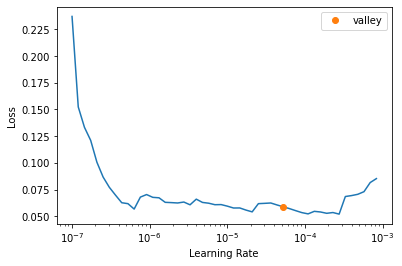

In [ ]:
learn.lr_find();

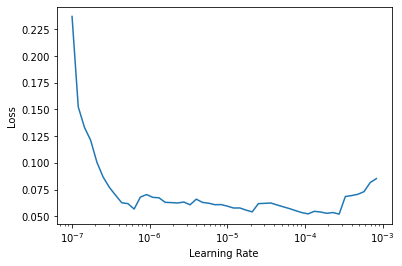

In [ ]:
learn.recorder.plot_lr_find(return_fig=true)

Use the above plot to pick adequate learning rates for your model. We need two learning rates since we are using [cyclic learning rates](https://arxiv.org/pdf/1506.01186.pdf):

- The first learning rate is just before the loss starts to increase, preferably 10x smaller than the rate at which the loss starts to increase. For instance, 1e-02 for our dataset.

- The second learning rate is 10x smaller than the first learning rate, so 1e-03 in our example.

The plot will be different for your dataset, so make sure to pick these two learning rates accordingly.

<br>Replace your chosen learning rates in the **slice** function below and let's train the model.

In [ ]:
# learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))
learn.fit_one_cycle(10, lr_max=None)

epoch,train_loss,valid_loss,error_rate,time
0,0.048289,1.141605,0.365854,00:12
1,0.237486,12.839123,0.951219,00:12
2,0.950589,33.972744,0.853659,00:12
3,1.200156,55.170036,0.853659,00:12
4,1.243354,13.838260,0.829268,00:11
5,1.211840,7.363820,0.804878,00:11
6,1.138247,1.251397,0.365854,00:13
7,1.058066,0.934399,0.317073,00:12
8,0.952244,0.770578,0.292683,00:11
9,0.903966,0.673964,0.219512,00:12


Great, we achieved a high classification accuracy with only a few lines of code and without much tuning of the parameters.

We are DONE but let's further interpret the results.

## 3. Results Interpretation and Visualization

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

We can start by visualizing a confusion matrix. The diagonal elements represent the number of images for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier.

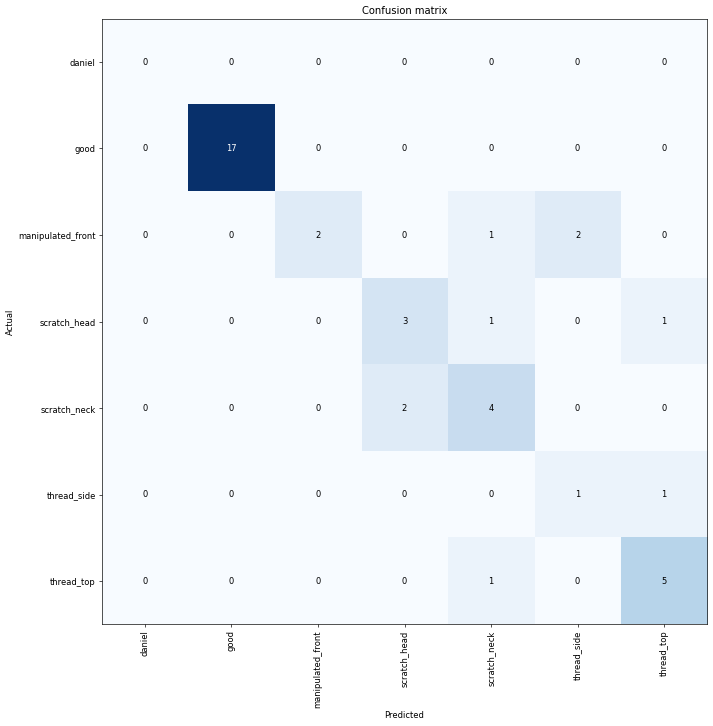

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can also plot images with top losses; in other words, the images that the model was most confused about. A high loss implies high confidence about the wrong answer.

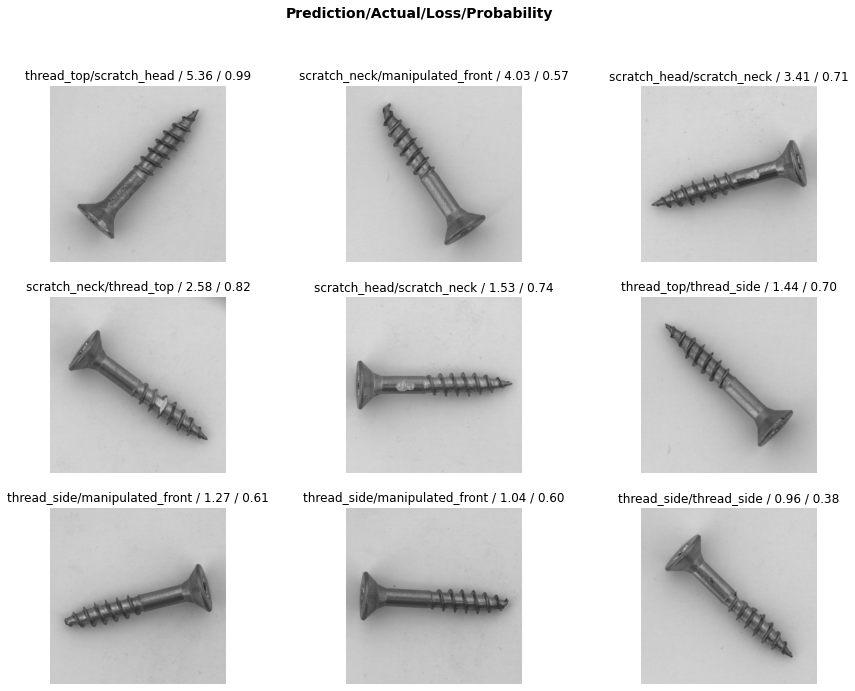

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
#path = PATH + "/good"
#path = PATH + "/manipulated_front"
# path = PATH + "/scratch_neck"
path = PATH + "/daniel"
path

'/content/gdrive/My Drive/daniel_test/daniel'

Images are shown along with top losses:<br>
prediction label / actual label / loss / probability of actual image class.

## 4. Testing the model on a new image

Let's now feed the model a new image it never seen before and see how well it classifies it.

Upload the image to the same folder of this notebook.

In [ ]:
get_image_files(path)[0]

Path('/content/gdrive/My Drive/daniel_test/daniel/000.png')

In [ ]:

def image_to_byte_array(image: Image) -> bytes:
  # BytesIO is a file-like buffer stored in memory
  imgByteArr = io.BytesIO()
  # image.save expects a file-like as a argument
  image.save(imgByteArr, format=image.format)
  # Turn the BytesIO object back into a bytes object
  imgByteArr = imgByteArr.getvalue()
  return imgByteArr

In [ ]:
#path = './' #The path of your test image
# img = open_image(BytesIO(get_image_files(path)[0]))
# img = open_image(get_image_files(path)[0])
img = Image.open(get_image_files(path)[0])

# img = BytesIO(img)
# img = open_image(get_image_files(path)[0])

pred_class,pred_idx,outputs = learn.predict(image_to_byte_array(img))
img.show()
print ("It is a {}, idx:{}".format(pred_class,pred_idx,outputs))

It is a daniel, idx:0


In [ ]:
#learn.export()

**FILE TO RUN FINALLY**

It is a scratch_neck


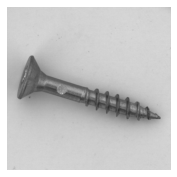

In [ ]:
#path = PATH + "/good"
#path = PATH + "/manipulated_front"
path = PATH + "/scratch_neck"
path
img = open_image(get_image_files(path)[5])
pred_class,pred_idx,outputs = model_export.predict(img)
img.show()
print ("It is a", pred_class)